In [19]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import fft
import math
import cv2
import os

In [20]:
import skimage
def fixe(x):
    return math.trunc(x)

def find(x):
    y = list()
    for i in range(x.shape[0]):
        if x[i]:
            y.append(i)
    return np.array(y)

def meshgrid(x, y):
    x1 = [i for i in x]
    x2 = []
    for i in range(len(y)):
        x2.append(x1)
    y2 = list()
    for i in y:
        y1 = list()
        for j in range(len(x)):
            y1.append(i)
        y2.append(y1)
    y2 = np.array(y2)
    x2 = np.array(x2)
    return [x2, y2]

def flip(A, dim = 0):
    return np.flip(A, axis = dim)

def rot90(A, k):
    if k == 2:
        return flip(flip(A, 0), 1)
    else:
        raise Exception("k!=2")
        
def sign(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0

def motion(len1, phi):
    len1 = max(1, len1)
    half = (len1-1)/2
    phi = (phi % 180) / 180 * math.pi
    
    cosphi = math.cos(phi)
    sinphi = math.sin(phi)
    xsign = sign(cosphi)
    linewdt = 1
    eps = pow(2, -52)
    
    sx = fixe(half*cosphi + linewdt*xsign - len1*eps)
    if xsign > 0:
        sx += 1
    else:
        sx -= 1
    sy = fixe(half*sinphi + linewdt - len1*eps)
    [x, y] = meshgrid([i for i in range(0, sx, xsign)], [i for i in range(sy)])
    dist2line = (y*cosphi-x*sinphi)
    
    rad = np.sqrt(np.square(x) + np.square(y))
    lastpix = np.where((rad >= half) & (abs(dist2line) <= linewdt))
    x2lastpix = half - np.absolute((x[lastpix] + dist2line[lastpix]*sinphi)/cosphi)
    dist2line[lastpix] = np.sqrt(np.square(dist2line[lastpix]) + np.square(x2lastpix))
    dist2line = linewdt + eps - np.absolute(dist2line)
    dist2line[dist2line<0] = 0
    h = rot90(dist2line,2)
    newh = np.zeros((2 * h.shape[0], 2 * h.shape[1]))
    newh[:h.shape[0], :h.shape[1]] = h
    newh[h.shape[0]:newh.shape[0], h.shape[1]:newh.shape[1]] = dist2line
    h = newh
    h = h / (np.sum(h) + eps / len1 / len1)
    return h.astype(np.float32)

def extension_PSF(image0,PSF0):
    [img_h,img_w] = image0.shape
    [h,w] = PSF0.shape
    PSF=np.zeros((img_h,img_w))
    PSF[0:h, 0:w] = PSF0             
    return PSF


def inverse (input, PSF, eps): # обратная фильтрация
    input_fft = fft.fft2(input)
    PSF_fft = fft.fft2 (PSF) + eps # мощность шума, которая известна, рассмотрим эпсилон
    result = fft.ifft2 (input_fft / PSF_fft) # вычислить обратное преобразование Фурье для F (u, v)
    #result = fft.fftshift(result)
    result = np.abs(result)
    return result

def wiener (input, PSF, eps, K = 0.01): # фильтра Винера, K = 0.01
    input_fft = fft.fft2(input)
    PSF_fft = fft.fft2(PSF) + eps
    PSF_fft_1 = np.conj(PSF_fft) / (np.abs(PSF_fft) ** 2 + K)
    result = fft.ifft2(input_fft * PSF_fft_1)
    #result = fft.fftshift(result)
    result = np.abs(result)
    return result


In [21]:
import numpy as np
import os
import cv2
def noisy(noise_typ,image, var = 0.1):
    if noise_typ == "gauss":
        row,col= image.shape
        ch = 1
        mean = 0
        #var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        noisy = image + gauss
        return noisy
    else:
        row,col = image.shape
        ch = 1
        s_vs_p = 0.5
        amount = var
        if var == 0.1:
            amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

      # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out

In [22]:
import skimage
from skimage import metrics
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import tensorflow as tf
from tensorflow.image import psnr

def PSNR(X, Y):
    return psnr(X, Y, 1)

def SSIM(X, Y):
    return tf.image.ssim_multiscale(X, Y, 1, filter_size = 6)

def get_rgb(x, batch_index=0, t_show=1):
    """Utility function to get a displayable rgb image 
    from a Sentinel-2 time series.
    """
    im = x[t_show, [2,1,0]].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im
def make_blurred(input, PSF, eps):
    input_fft = fft.fft2 (input) # преобразование Фурье двумерного массива
    PSF_fft = fft.fft2(PSF) + eps
    blurred = fft.ifft2(input_fft * PSF_fft)
    blurred = np.abs(blurred)
    blurred = noisy('gauss', blurred, 0.0001)
    return blurred


In [23]:
path = 'D:\\мфти\\диплом\\Новая папка\\диплом\\pictures\\comp'

In [24]:
import os
import numpy as np
from PIL import Image

In [14]:
with Image.open(os.path.join(path, 'origtest_3.jpeg')) as im:
    dataorig = np.array(im) / 255
print(dataorig.shape)
with Image.open(os.path.join(path, 'blurtest_3.jpeg')) as im:
    datablur = np.array(im) / 255
print(datablur.shape)
with Image.open(os.path.join(path, 'restoredtestwin_3.jpeg')) as im:
    datawin = np.array(im) / 255
print(datawin.shape)
with Image.open(os.path.join(path, 'restoredtest_3.jpeg')) as im:
    datann = np.array(im) / 255
print(datann.shape)

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


In [16]:
print(PSNR(dataorig, dataorig), SSIM(dataorig, datablur))

Tensor("PSNR_1/Identity:0", shape=(), dtype=float32) Tensor("MS-SSIM_1/Mean:0", shape=(), dtype=float32)


In [18]:
import torch
Path = 'D:\\мфти\\диплом\\Новая папка\\'
PATH_TO_TEST_blurred = Path + 'data\\test\\blurred'
PATH_TO_TEST_param = Path + 'data\\test\\param'
PATH_TO_TEST_orig = Path + 'data\\test\\orig'
files = os.listdir(PATH_TO_TEST_blurred)
data1 = np.load(os.path.join(PATH_TO_TEST_blurred, files[0])).astype(np.float32)
data2 = np.load(os.path.join(PATH_TO_TEST_orig, files[0])).astype(np.float32)
li = np.load(os.path.join(PATH_TO_TEST_param, files[0]))
x = np.empty(data1.shape)
q = np.empty(data1.shape)
z = np.empty(data1.shape)
y = np.empty(data1.shape)
from IPython.display import clear_output

mb = np.load(os.path.join(Path, 'data', 'm', 'blurred', files[0]))
mo = np.load(os.path.join(Path, 'data', 'm', 'orig', files[0]))
mib = np.load(os.path.join(Path, 'data', 'm', 'blurred', files[0]))
mio = np.load(os.path.join(Path, 'data', 'm', 'orig', files[0]))
psnrinv = 0
ssiminv = 0
count = 0
psnrwin = 0
psnrb = 0
ssimb = 0
ssimwin = 0
for j in range(data1.shape[0]):
    clear_output(wait = True)
    print(str(j) + '/' + str(data1.shape[0]))
    li1 = li[1][j]
    li0 = li[0][j]
        #print(li0, li1)
    PSF = motion(li0 * 4 + 6, li1 * 180)
    PSF = extension_PSF(data1[j][0],PSF)
    for k in range(data1.shape[1]):
        count += 1
        y[j][k] = data2[j][k]
        z[j][k] = data1[j][k]
        x[j][k] = inverse(z[j][k], PSF, 0.011)
        q[j][k] = wiener(z[j][k], PSF, 0.01, 0.01)
        psnrb += PSNR(y[j][k], z[j][k])
        psnrinv += PSNR(y[j][k], x[j][k])
        psnrwin += PSNR(y[j][k], q[j][k])
        ssimb += SSIM(y[j][k], z[j][k])
        ssiminv += SSIM(y[j][k], x[j][k])
        ssimwin += SSIM(y[j][k], q[j][k])
        x[j][k] = denormalize_image(x[j][k], mb[j][k], mib[j][k])
        y[j][k] = denormalize_image(y[j][k], mo[j][k], mio[j][k])
        z[j][k] = denormalize_image(z[j][k], mb[j][k], mib[j][k])
        q[j][k] = denormalize_image(q[j][k], mb[j][k], mib[j][k])
        #psnrsum += PSNR(x[j], y[j])
        #ssimsum += SSIM(x[j], y[j])
print(psnrb / count, psnrinv / count, psnrwin / count)
print(ssimb / count, ssiminv / count, ssimwin / count)
fix, axes = plt.subplots(1, 4, figsize=(20,10))
x = torch.from_numpy(x)
y = torch.from_numpy(y)
z = torch.from_numpy(z)
k = torch.from_numpy(q)
axes[0].imshow(get_rgb(y, batch_index=0))
axes[1].imshow(get_rgb(z, batch_index=0))
axes[2].imshow(get_rgb(x, batch_index=0))
axes[3].imshow(get_rgb(k, batch_index=0))
axes[0].set_title('Original.')
axes[1].set_title('Blurred.')
axes[2].set_title('Restored.')
plt.show()

0/43


NameError: name 'motion' is not defined

In [7]:
#!g1.1
from PIL import Image
y = get_rgb(x)
print(x.shape)
im = Image.fromarray((y * 255).astype(np.uint8))
im.save("deblur_inverse.jpeg")
y = get_rgb(k)
print(x.shape)
im = Image.fromarray((y * 255).astype(np.uint8))
im.save("deblur_wiener.jpeg")

torch.Size([43, 10, 128, 128])
torch.Size([43, 10, 128, 128])


In [15]:
import random
from IPython.display import clear_output
import math
Path = 'D:\\мфти\\диплом\\Новая папка\\data'
PATH_TO_TEST_blurred = Path + '\\test\\blurred'
PATH_TO_TEST_param = Path + '\\test\\param'
PATH_TO_TEST_orig = Path + '\\test\\orig'
files = os.listdir(PATH_TO_TEST_blurred)
print("Вариант 1 длину смаза и угол читаем из файла")
a_list = [6, 7, 8, 9, 10]
distribution = [0.15, 0.2, 0.3, 0.2, 0.15]
psnrinv = 0
ssiminv = 0
count = 0
psnrwin = 0
psnrb = 0
ssimb = 0
ssimwin = 0
for i in range(len(files)):
    clear_output(wait = True)
    print(str(i) + '/' + str(len(files)))
    #if count:
        #print(count)
        #print(psnrb / count)
        #print(ssimb / count)
        #print(psnrwin / count)
        #print(ssimwin / count)
        #print(psnrinv / count)
        #print(ssiminv / count)
    data1 = np.load(os.path.join(PATH_TO_TEST_blurred, files[i]))
    data2 = np.load(os.path.join(PATH_TO_TEST_orig, files[i]))
    li = np.load(os.path.join(PATH_TO_TEST_param, files[i]))
    
    for j in range(data1.shape[0]):
        li0 = li[0][j]
        li1 = li[1][j]
        PSF = motion(li0 * 4 + 6, li1 * 180)
        PSF = extension_PSF(data1[j][k],PSF)
        #print(li0, li1)
        for k in range(data1[j].shape[0]):
            count += 1
            z = data1[j][k]
            y = inverse(z, PSF, 0.01)
            x = data2[j][k]
            if math.isnan(PSNR(x, y)):
                count -= 1
                continue
            psnrinv += PSNR(x, y)
            ssiminv += SSIM(x, y)
            y = wiener(z, PSF, 0.01, 0.01)
            psnrwin += PSNR(x, y)
            ssimwin += SSIM(x, y)
            z = data1[j][k]
            psnrb += PSNR(x, z)
            ssimb += SSIM(x, z)
psnrb /= count
ssimb /= count
psnrwin /= count
ssimwin /= count
psnrinv /= count
ssiminv /= count
print("Среднее PSNR для смазанных изображений: " + str(psnrb))
print("Среднее SSIM для смазанных изображений: " + str(ssimb))
print("Среднее PSNR для инверсной фильтрации: " + str(psnrinv))
print("Среднее SSIM для инверсной фильтрации: " + str(ssiminv))
print("Среднее PSNR для Фильтра Винера: " + str(psnrwin))
print("Среднее SSIM для Фильтра Винера: " + str(ssimwin))

370/371
20.94396404502357
0.6854061373965168
27.567736154143216
0.8229625166544288
8.76399581893332
0.08407485574225025
Среднее PSNR для смазанных изображений: 20.94539458615122
Среднее SSIM для смазанных изображений: 0.6855400067395996
Среднее PSNR для инверсной фильтрации: 8.763667494047095
Среднее SSIM для инверсной фильтрации: 0.08404303209552244
Среднее PSNR для Фильтра Винера: 27.568236388881697
Среднее SSIM для Фильтра Винера: 0.822924834358697


(43, 10, 128, 128)
(43, 10, 128, 128)
(43, 10, 128, 128)
(43, 10, 128, 128)
(43, 10, 128, 128)


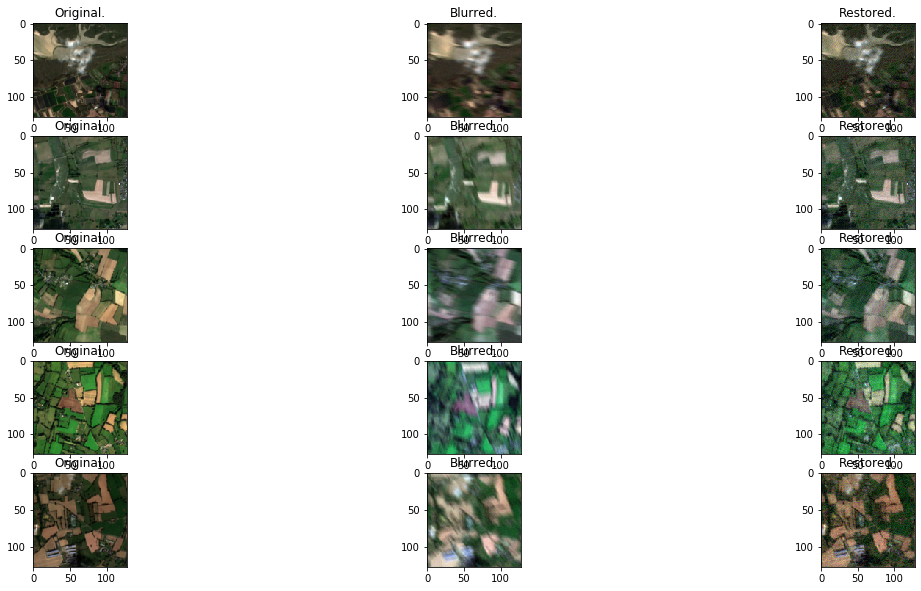

In [27]:
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
import os
bid = 0 
fix, axes = plt.subplots(5, 3, figsize=(20,10))
files1 = os.listdir(os.path.join('D:\\мфти', 'диплом', 'Новая папка', 'data', 'test', 'orig'))
for i in range(5):
    data = np.load(os.path.join('D:\\мфти\\диплом\\Новая папка\\data\\test\\blurred', files1[i]))
    label = np.load(os.path.join('D:\\мфти\\диплом\\Новая папка\\data\\test\\orig', files1[i]))
    #print(data.shape)
    li = np.load(os.path.join(PATH_TO_TEST_param, files[i]))
    predict = np.empty(data.shape)
    for j in range(data.shape[0]):
        li1 = li[1][j]
        li0 = li[0][j]
        #print(li0, li1)
        PSF = motion(li0 * 4 + 6, li1 * 180)
        PSF = extension_PSF(data1[j][0],PSF)
        for k in range(data.shape[1]):
            predict[j][k] = wiener(data[j][k], PSF, 0.01, 0.01)
    #print(predict.shape, data.shape)
    #predict = predict.transpose(0, 3, 1, 2)
    x = torch.from_numpy(label)
    y = torch.from_numpy(data)
    z = torch.from_numpy(predict)
    print(predict.shape)
    np.save('win_' + str(i) + '.npy', predict)
    axes[i][0].imshow(get_rgb(x, t_show = 2))
    axes[i][1].imshow(get_rgb(y, t_show = 2))
    axes[i][2].imshow(get_rgb(z, t_show = 2))

      #axes[1,0].imshow(target_heatmap[bid].squeeze())
      #axes[1,1].imshow(instance_ids[bid].squeeze(), cmap='prism', alpha=.6)
      #axes[1,2].imshow(pixel_semantic_annotation[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)
      #
    axes[i][0].set_title('Original.')
    axes[i][1].set_title('Blurred.')
    axes[i][2].set_title('Restored.')
    q = get_rgb(x, t_show = 2)
    #print(q.shape)
    im = Image.fromarray((q * 255).astype(np.uint8))
    im.save("origtestwin_" + str(i) + ".jpeg")
    q = get_rgb(y, t_show = 2)
    #print(q.shape)
    im = Image.fromarray((q * 255).astype(np.uint8))
    im.save("blurtestwin_" + str(i) + ".jpeg")
    q = get_rgb(z, t_show = 2)
    #print(q.shape)
    im = Image.fromarray((q * 255).astype(np.uint8))
    im.save("restoredtestwin_" + str(i) + '.jpeg')

""""axes[1,0].set_title('Centerness Ground Truth.')
axes[1,1].set_title('Instance masks.')
axes[1,2].set_title('Semantic labels.')"""

plt.show()

In [28]:
d = np.load('win_3.npy')

In [29]:
 print(d.shape)

(43, 10, 128, 128)


In [ ]:
print(psnrwin)

42/43
20.95009019021226 -8.846324581491377 15.816409267935748
0.6995746849461159 0.0016782559725912632 0.5500647160081


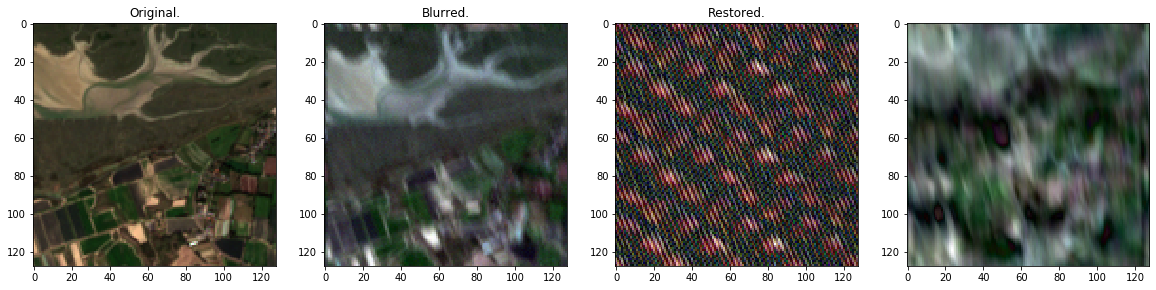

In [16]:
import torch
Path = 'D:\\мфти\\диплом\\Новая папка\\'
PATH_TO_TEST_blurred = Path + 'data\\test\\blurred'
PATH_TO_TEST_param = Path + 'data\\test\\param'
PATH_TO_TEST_orig = Path + 'data\\test\\orig'
files = os.listdir(PATH_TO_TEST_blurred)
data1 = np.load(os.path.join(PATH_TO_TEST_blurred, files[0])).astype(np.float32)
data2 = np.load(os.path.join(PATH_TO_TEST_orig, files[0])).astype(np.float32)
li = np.load(os.path.join(PATH_TO_TEST_param, files[0]))
x = np.empty(data1.shape)
q = np.empty(data1.shape)
z = np.empty(data1.shape)
y = np.empty(data1.shape)
from IPython.display import clear_output

mb = np.load(os.path.join(Path, 'data', 'm', 'blurred', files[0]))
mo = np.load(os.path.join(Path, 'data', 'm', 'orig', files[0]))
mib = np.load(os.path.join(Path, 'data', 'm', 'blurred', files[0]))
mio = np.load(os.path.join(Path, 'data', 'm', 'orig', files[0]))
psnrinv = 0
ssiminv = 0
count = 0
psnrwin = 0
psnrb = 0
ssimb = 0
ssimwin = 0
for j in range(data1.shape[0]):
    clear_output(wait = True)
    print(str(j) + '/' + str(data1.shape[0]))
    li1 = li[1][j] + random.uniform(-0.5 / 180, 0.5 / 180)
    li0 = random.choices(a_list, distribution)[0]
        #print(li0, li1)
    PSF = motion(li0 * 4 + 6, li1 * 180)
    PSF = extension_PSF(data1[j][0],PSF)
    for k in range(data1.shape[1]):
        count += 1
        x[j][k] = inverse(data1[j][k], PSF, 0.011)
        y[j][k] = data2[j][k]
        z[j][k] = data1[j][k]
        q[j][k] = wiener(data1[j][k], PSF, 0.011, 0.1)
        psnrb += PSNR(y[j][k], z[j][k])
        psnrinv += PSNR(y[j][k], x[j][k])
        psnrwin += PSNR(y[j][k], q[j][k])
        ssimb += SSIM(y[j][k], z[j][k])
        ssiminv += SSIM(y[j][k], x[j][k])
        ssimwin += SSIM(y[j][k], q[j][k])
        x[j][k] = denormalize_image(x[j][k], mb[j][k], mib[j][k])
        y[j][k] = denormalize_image(y[j][k], mo[j][k], mio[j][k])
        z[j][k] = denormalize_image(z[j][k], mb[j][k], mib[j][k])
        q[j][k] = denormalize_image(q[j][k], mb[j][k], mib[j][k])
        #psnrsum += PSNR(x[j], y[j])
        #ssimsum += SSIM(x[j], y[j])
print(psnrb / count, psnrinv / count, psnrwin / count)
print(ssimb / count, ssiminv / count, ssimwin / count)
fix, axes = plt.subplots(1, 4, figsize=(20,10))
x = torch.from_numpy(x)
y = torch.from_numpy(y)
z = torch.from_numpy(z)
k = torch.from_numpy(q)
axes[0].imshow(get_rgb(y, batch_index=0))
axes[1].imshow(get_rgb(z, batch_index=0))
axes[2].imshow(get_rgb(x, batch_index=0))
axes[3].imshow(get_rgb(k, batch_index=0))
axes[0].set_title('Original.')
axes[1].set_title('Blurred.')
axes[2].set_title('Restored.')
plt.show()

In [17]:
#!g1.1
y = get_rgb(x)
print(x.shape)
im = Image.fromarray((y * 255).astype(np.uint8))
im.save("deblur_inverse_ver2.jpeg")
#!g1.1
y = get_rgb(k)
print(x.shape)
im = Image.fromarray((y * 255).astype(np.uint8))
im.save("deblur_wiener_ver2.jpeg")

torch.Size([43, 10, 128, 128])
torch.Size([43, 10, 128, 128])


In [18]:
import random
from IPython.display import clear_output
Path = 'D:\\мфти\\диплом\\Новая папка\\data'
PATH_TO_TEST_blurred = Path + '\\test\\blurred'
PATH_TO_TEST_param = Path + '\\test\\param'
PATH_TO_TEST_orig = Path + '\\test\\orig'
files = os.listdir(PATH_TO_TEST_blurred)
print("Вариант 2 длину смаза выбираем случайно")
a_list = [6, 7, 8, 9, 10]
distribution = [0.15, 0.2, 0.3, 0.2, 0.15]
psnrinv = 0
ssiminv = 0
count = 0
psnrwin = 0
psnrb = 0
ssimb = 0
ssimwin = 0
for i in range(len(files)):
    clear_output(wait = True)
    print(str(i) + '/' + str(len(files)))
    #if count:
        #print(psnrb / count)
        #print(ssimb / count)
        #print(psnrwin / count)
        #print(ssimwin / count)
        #print(psnrinv / count)
        #print(ssiminv / count)
    data1 = np.load(os.path.join(PATH_TO_TEST_blurred, files[i]))
    data2 = np.load(os.path.join(PATH_TO_TEST_orig, files[i]))
    li = np.load(os.path.join(PATH_TO_TEST_param, files[i]))
    
    for j in range(data1.shape[0]):
        li1 = li[1][j] + random.uniform(-0.5 / 180, 0.5 / 180)
        li0 = random.choices(a_list, distribution)[0]
        #print(li0, li1)
        for k in range(data1[j].shape[0]):
            count += 1
            PSF = motion(li0 * 4 + 6, li1 * 180)
            PSF = extension_PSF(data1[j][k],PSF)
            y = inverse(data1[j][k], PSF, 0.01)
            x = data2[j][k]
            if math.isnan(PSNR(x, y)):
                count -= 1
                continue
            psnrinv += PSNR(x, y)
            ssiminv += SSIM(x, y)
            y = wiener(data1[j][k], PSF, 0.01, 0.1)
            psnrwin += PSNR(x, y)
            ssimwin += SSIM(x, y)
            z = data1[j][k]
            psnrb += PSNR(x, z)
            ssimb += SSIM(x, z)
psnrb /= count
ssimb /= count
psnrwin /= count
ssimwin /= count
psnrinv /= count
ssiminv /= count
print("Среднее PSNR для смазанных изображений: " + str(psnrb))
print("Среднее SSIM для смазанных изображений: " + str(ssimb))
print("Среднее PSNR для инверсной фильтрации: " + str(psnrinv))
print("Среднее SSIM для инверсной фильтрации: " + str(ssiminv))
print("Среднее PSNR для Фильтра Винера: " + str(psnrwin))
print("Среднее SSIM для Фильтра Винера: " + str(ssimwin))

370/371
20.94396404502357
0.6854061373965168
16.20190038945649
0.5390844833648724
-9.999371221947305
0.0011653871909941527
Среднее PSNR для смазанных изображений: 20.94539458615122
Среднее SSIM для смазанных изображений: 0.6855400067395996
Среднее PSNR для инверсной фильтрации: -10.000380208747433
Среднее SSIM для инверсной фильтрации: 0.0011658061095630766
Среднее PSNR для Фильтра Винера: 16.202210647509613
Среднее SSIM для Фильтра Винера: 0.5392158903677786


42/43
20.95009019021226 8.59800177984157 25.09900127330355
0.6995746849461159 0.0746181323407192 0.8898209562113121


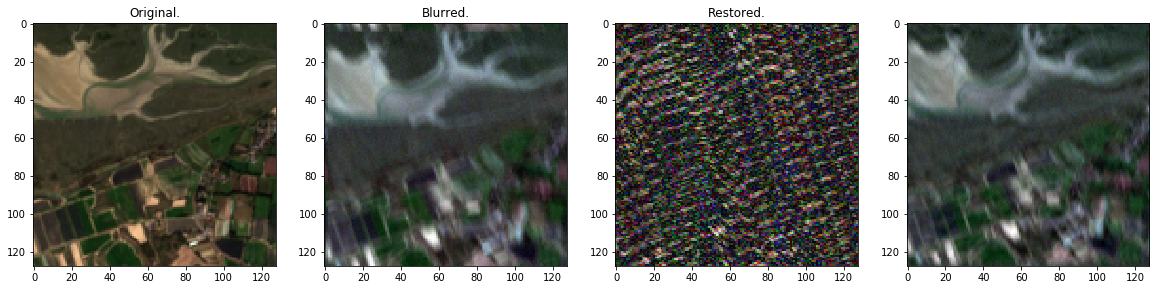

In [19]:
import torch
Path = 'D:\\мфти\\диплом\\Новая папка\\'
PATH_TO_TEST_blurred = Path + 'data\\test\\blurred'
PATH_TO_TEST_param = Path + 'data\\test\\param'
PATH_TO_TEST_orig = Path + 'data\\test\\orig'
files = os.listdir(PATH_TO_TEST_blurred)
data1 = np.load(os.path.join(PATH_TO_TEST_blurred, files[0])).astype(np.float32)
data2 = np.load(os.path.join(PATH_TO_TEST_orig, files[0])).astype(np.float32)
li = np.load(os.path.join(PATH_TO_TEST_param, files[0]))
x = np.empty(data1.shape)
q = np.empty(data1.shape)
z = np.empty(data1.shape)
y = np.empty(data1.shape)

mb = np.load(os.path.join(Path, 'data', 'm', 'blurred', files[0]))
mo = np.load(os.path.join(Path, 'data', 'm', 'orig', files[0]))
mib = np.load(os.path.join(Path, 'data', 'm', 'blurred', files[0]))
mio = np.load(os.path.join(Path, 'data', 'm', 'orig', files[0]))
psnrinv = 0
ssiminv = 0
count = 0
psnrwin = 0
psnrb = 0
ssimb = 0
ssimwin = 0
for j in range(data1.shape[0]):
    clear_output(wait = True)
    print(str(j) + '/' + str(data1.shape[0]))
    li1 = li[1][j] + random.uniform(-0.5 / 180, 0.5 / 180)
    li0 = 0.5
        #print(li0, li1)
    PSF = motion(li0 * 4 + 6, li1 * 180)
    PSF = extension_PSF(data1[j][0],PSF)
    for k in range(data1.shape[1]):
        count += 1
        x[j][k] = inverse(data1[j][k], PSF, 0.011)
        y[j][k] = data2[j][k]
        z[j][k] = data1[j][k]
        q[j][k] = wiener(data1[j][k], PSF, 0.011, 0.1)
        psnrb += PSNR(y[j][k], z[j][k])
        psnrinv += PSNR(y[j][k], x[j][k])
        psnrwin += PSNR(y[j][k], q[j][k])
        ssimb += SSIM(y[j][k], z[j][k])
        ssiminv += SSIM(y[j][k], x[j][k])
        ssimwin += SSIM(y[j][k], q[j][k])
        x[j][k] = denormalize_image(x[j][k], mb[j][k], mib[j][k])
        y[j][k] = denormalize_image(y[j][k], mo[j][k], mio[j][k])
        z[j][k] = denormalize_image(z[j][k], mb[j][k], mib[j][k])
        q[j][k] = denormalize_image(q[j][k], mb[j][k], mib[j][k])
        #psnrsum += PSNR(x[j], y[j])
        #ssimsum += SSIM(x[j], y[j])
print(psnrb / count, psnrinv / count, psnrwin / count)
print(ssimb / count, ssiminv / count, ssimwin / count)
fix, axes = plt.subplots(1, 4, figsize=(20,10))
x = torch.from_numpy(x)
y = torch.from_numpy(y)
z = torch.from_numpy(z)
k = torch.from_numpy(q)
axes[0].imshow(get_rgb(y, batch_index=0))
axes[1].imshow(get_rgb(z, batch_index=0))
axes[2].imshow(get_rgb(x, batch_index=0))
axes[3].imshow(get_rgb(k, batch_index=0))
axes[0].set_title('Original.')
axes[1].set_title('Blurred.')
axes[2].set_title('Restored.')
plt.show()

In [20]:
#!g1.1
y = get_rgb(x)
print(x.shape)
im = Image.fromarray((y * 255).astype(np.uint8))
im.save("deblur_inverse_ver3.jpeg")
#!g1.1
y = get_rgb(k)
print(x.shape)
im = Image.fromarray((y * 255).astype(np.uint8))
im.save("deblur_wiener_ver3.jpeg")

torch.Size([43, 10, 128, 128])
torch.Size([43, 10, 128, 128])


In [21]:
import random
from IPython.display import clear_output
Path = 'D:\\мфти\\диплом\\Новая папка\\data'
PATH_TO_TEST_blurred = Path + '\\test\\blurred'
PATH_TO_TEST_param = Path + '\\test\\param'
PATH_TO_TEST_orig = Path + '\\test\\orig'
files = os.listdir(PATH_TO_TEST_blurred)
print("Вариант 2 длину смаза выбираем случайно")
a_list = [6, 7, 8, 9, 10]
distribution = [0.15, 0.2, 0.3, 0.2, 0.15]
psnrinv = 0
ssiminv = 0
count = 0
psnrwin = 0
psnrb = 0
ssimb = 0
ssimwin = 0
for i in range(len(files)):
    clear_output(wait = True)
    print(str(i) + '/' + str(len(files)))
    if count:
        print(psnrb / count)
        print(ssimb / count)
        print(psnrwin / count)
        print(ssimwin / count)
        print(psnrinv / count)
        print(ssiminv / count)
    data1 = np.load(os.path.join(PATH_TO_TEST_blurred, files[i]))
    data2 = np.load(os.path.join(PATH_TO_TEST_orig, files[i]))
    li = np.load(os.path.join(PATH_TO_TEST_param, files[i]))
    
    for j in range(data1.shape[0]):
        li1 = li[1][j] + random.uniform(-0.5 / 180, 0.5 / 180)
        li0 = 0.5
        #print(li0, li1)
        for k in range(data1[j].shape[0]):
            count += 1
            PSF = motion(li0 * 4 + 6, li1 * 180)
            PSF = extension_PSF(data1[j][k],PSF)
            y = inverse(data1[j][k], PSF, 0.01)
            x = data2[j][k]
            if math.isnan(PSNR(x, y)):
                count -= 1
                continue
            psnrinv += PSNR(x, y)
            ssiminv += SSIM(x, y)
            y = wiener(data1[j][k], PSF, 0.01, 0.1)
            psnrwin += PSNR(x, y)
            ssimwin += SSIM(x, y)
            z = data1[j][k]
            psnrb += PSNR(x, z)
            ssimb += SSIM(x, z)
psnrb /= count
ssimb /= count
psnrwin /= count
ssimwin /= count
psnrinv /= count
ssiminv /= count
print("Среднее PSNR для смазанных изображений: " + str(psnrb))
print("Среднее SSIM для смазанных изображений: " + str(ssimb))
print("Среднее PSNR для инверсной фильтрации: " + str(psnrinv))
print("Среднее SSIM для инверсной фильтрации: " + str(ssiminv))
print("Среднее PSNR для Фильтра Винера: " + str(psnrwin))
print("Среднее SSIM для Фильтра Винера: " + str(ssimwin))

370/371
20.94396404502357
0.6854061373965168
25.082143846313443
0.8788618219812441
7.574543599539654
0.0643245454931286
Среднее PSNR для смазанных изображений: 20.94539458615122
Среднее SSIM для смазанных изображений: 0.6855400067395996
Среднее PSNR для инверсной фильтрации: 7.57530772704152
Среднее SSIM для инверсной фильтрации: 0.06430565042371994
Среднее PSNR для Фильтра Винера: 25.083308361040107
Среднее SSIM для Фильтра Винера: 0.8789285578013677


In [5]:
import random
import matplotlib.pyplot as plt
import numpy as np
from numpy import fft
import math
import cv2
import os
from IPython.display import clear_output
import math
Path = 'D:\\мфти\\диплом\\Новая папка\\data'
PATH_TO_TEST_blurred = Path + '\\test\\blurred'
PATH_TO_TEST_param = Path + '\\test\\param'
PATH_TO_TEST_orig = Path + '\\test\\orig'
files = os.listdir(PATH_TO_TEST_blurred)
print("Вариант 1 длину смаза и угол читаем из файла")
a_list = [6, 7, 8, 9, 10]
distribution = [0.15, 0.2, 0.3, 0.2, 0.15]
c1 = 0
su = 0
count = 0
for i in range(len(files)):
    clear_output(wait = True)
    print(str(i) + '/' + str(len(files)))
    #if count:
        #print(count)
        #print(psnrb / count)
        #print(ssimb / count)
        #print(psnrwin / count)
        #print(ssimwin / count)
        #print(psnrinv / count)
        #print(ssiminv / count)
    data2 = np.load(os.path.join(PATH_TO_TEST_orig, files[i]))
    data = data2
    
    if not(math.isnan(np.sum(data))):
        count += data.shape[0] * data.shape[1] * data.shape[2] * data.shape[3]
        su += np.sum(data)
        c1 += 1
mean = su / count
print(c1)
print(mean)
            

370/371
279
0.38179235017341145


In [7]:
print(count / 128 / 128 / 10)

12066.0
